In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
import pmdarima as pm
import statsmodels.tsa.api as tsa
from pmdarima.model_selection import train_test_split
from pmdarima.arima.utils import ndiffs, nsdiffs

# Set wide fig size for plots
plt.rcParams['figure.figsize']=(12,3)

In [3]:
def plot_forecast(ts_train, ts_test, forecast_df, n_train_lags=None, 
                  figsize=(10,4), title='Comparing Forecast vs. True Data'):
    ### PLot training data, and forecast (with upper/,lower ci)
    fig, ax = plt.subplots(figsize=figsize)

    # setting the number of train lags to plot if not specified
    if n_train_lags==None:
        n_train_lags = len(ts_train)
            
    # Plotting Training  and test data
    ts_train.iloc[-n_train_lags:].plot(ax=ax, label="train")
    ts_test.plot(label="test", ax=ax)

    # Plot forecast
    forecast_df['mean'].plot(ax=ax, color='green', label="forecast")

    # Add the shaded confidence interval
    ax.fill_between(forecast_df.index, 
                    forecast_df['mean_ci_lower'],
                   forecast_df['mean_ci_upper'],
                   color='green', alpha=0.3,  lw=2)

    # set the title and add legend
    ax.set_title(title)
    ax.legend();
    
    return fig, ax


In [4]:
def get_adfuller_results(ts, alpha=.05, label='adfuller', **kwargs): 
    (test_stat, pval, nlags, nobs, crit_vals_d, 
    icbest ) = tsa.adfuller(ts, **kwargs)
    # Converting output to a dictionary with the interpretation of p
    adfuller_results = {'Test Statistic': test_stat,
                        "# of Lags Used":nlags, 
                       '# of Observations':nobs,
                        'p-value': round(pval,6),
                        'alpha': alpha,
                       'sig/stationary?': pval < alpha}
    return pd.DataFrame(adfuller_results, index =[label])

In [5]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

def regression_metrics_ts(ts_true, ts_pred, label="", verbose=True, output_dict=False,):
    # Get metrics
    mae = mean_absolute_error(ts_true, ts_pred)
    mse = mean_squared_error(ts_true, ts_pred)
    rmse = mean_squared_error(ts_true, ts_pred, squared=False)
    r_squared = r2_score(ts_true, ts_pred)
    mae_perc = mean_absolute_percentage_error(ts_true, ts_pred) * 100

    if verbose == True:
        # Print Result with label
        header = "---" * 20
        print(header, f"Regression Metrics: {label}", header, sep="\n")
        print(f"- MAE = {mae:,.3f}")
        print(f"- MSE = {mse:,.3f}")
        print(f"- RMSE = {rmse:,.3f}")
        print(f"- R^2 = {r_squared:,.3f}")
        print(f"- MAPE = {mae_perc:,.2f}%")

    if output_dict == True:
        metrics = {
            "Label": label,
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse,
            "R^2": r_squared,
            "MAPE(%)": mae_perc,
        }
        return metrics

In [6]:
def plot_acf_pacf(ts, nlags=40, figsize=(10, 5), 
                  annotate_sig=False, alpha=.05,
                 acf_kws={}, pacf_kws={},  
                  annotate_seas=False, m = None,
                 seas_color='black'):
    
    fig, axes = plt.subplots(nrows=2, figsize=figsize)

    
    # Sig lags line style
    sig_vline_kwargs = dict( ls=':', lw=1, zorder=0, color='red')

    # ACF
    tsa.graphics.plot_acf(ts, ax=axes[0], lags=nlags, **acf_kws)
    
    ## Annotating sig acf lags
    if annotate_sig == True:
        sig_acf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='ACF')
        for lag in sig_acf_lags:
            axes[0].axvline(lag,label='sig', **sig_vline_kwargs )

    # PACF
    tsa.graphics.plot_pacf(ts,ax=axes[1], lags=nlags, **pacf_kws)
    
    ## Annotating sig pacf lags
    if annotate_sig == True:
        ## ANNOTATING SIG LAGS
        sig_pacf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='PACF')
        for lag in sig_pacf_lags:
            axes[1].axvline(lag, label='sig', **sig_vline_kwargs)



    
    ### ANNOTATE SEASONS
    if annotate_seas == True:
        # Ensure m was defined
        if m is None:
            raise Exception("Must define value of m if annotate_seas=True.")

        ## Calculate number of complete seasons to annotate
        n_seasons = nlags//m 

        # Seasonal Lines style
        seas_vline_kwargs = dict( ls='--',lw=1, alpha=.7, color=seas_color, zorder=-1)
        
        ## for each season, add a line
        for i in range(1, n_seasons+1):
            axes[0].axvline(m*i, **seas_vline_kwargs, label="season")
            axes[1].axvline(m*i, **seas_vline_kwargs, label="season")

    fig.tight_layout()
    
    return fig

In [7]:
hvd = pd.read_csv('/Users/marcolaureano2/Documents/GitHub/Zillow/City_zhvi_uc_sfrcondo_tier_0.33_0.67_sm_sa_month.csv')

In [8]:
hvd.columns

Index(['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName',
       'State', 'Metro', 'CountyName', '2000-01-31', '2000-02-29',
       ...
       '2021-12-31', '2022-01-31', '2022-02-28', '2022-03-31', '2022-04-30',
       '2022-05-31', '2022-06-30', '2022-07-31', '2022-08-31', '2022-09-30'],
      dtype='object', length=281)

In [9]:
hvd

,RegionID,SizeRank,RegionName,RegionType,StateName,State,Metro,CountyName,2000-01-31,2000-02-29,...,2021-12-31,2022-01-31,2022-02-28,2022-03-31,2022-04-30,2022-05-31,2022-06-30,2022-07-31,2022-08-31,2022-09-30
0,6181,0,New York,city,NY,NY,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,253690.0,255517.0,...,741586.0,745686.0,750578.0,756734.0,762321.0,768797.0,773944.0,777692.0,779960.0,781622.0
1,12447,1,Los Angeles,city,CA,CA,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles County,234181.0,234401.0,...,924019.0,928991.0,937936.0,953874.0,973168.0,990391.0,992337.0,992630.0,978196.0,966595.0
2,39051,2,Houston,city,TX,TX,"Houston-The Woodlands-Sugar Land, TX",Harris County,109068.0,109079.0,...,245783.0,248718.0,252080.0,256435.0,261101.0,265558.0,268901.0,271059.0,272400.0,272639.0
3,17426,3,Chicago,city,IL,IL,"Chicago-Naperville-Elgin, IL-IN-WI",Cook County,166139.0,166536.0,...,302821.0,305104.0,306404.0,308303.0,309649.0,312487.0,314663.0,315910.0,315587.0,315429.0
4,6915,4,San Antonio,city,TX,TX,"San Antonio-New Braunfels, TX",Bexar County,114794.0,114975.0,...,269323.0,274032.0,278464.0,284127.0,289739.0,294776.0,297727.0,298796.0,299124.0,298951.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22462,236350,28439,Palisades,city,TX,TX,"Amarillo, TX",Randall County,NaN,NaN,...,198490.0,198467.0,196420.0,192002.0,191634.0,189383.0,191134.0,191343.0,192384.0,192110.0
22463,40403,28439,Port Mansfield,city,TX,TX,"Raymondville, TX",Willacy County,NaN,NaN,...,229251.0,232984.0,238245.0,240154.0,242470.0,243119.0,249098.0,255572.0,261910.0,264685.0
22464,54740,28439,Tribes Hill,city,NY,NY,"Amsterdam, NY",Montgomery County,53380.0,53662.0,...,132490.0,134951.0,137470.0,137430.0,137413.0,137615.0,138908.0,140096.0,141573.0,142438.0
22465,249186,28439,Derby Center,city,VT,VT,NaN,Orleans County,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,258191.0,261607.0,264571.0,266255.0


In [10]:
size_filter = hvd['SizeRank'] < 4

In [11]:
hvd_4 = hvd[size_filter]
hvd_4

,RegionID,SizeRank,RegionName,RegionType,StateName,State,Metro,CountyName,2000-01-31,2000-02-29,...,2021-12-31,2022-01-31,2022-02-28,2022-03-31,2022-04-30,2022-05-31,2022-06-30,2022-07-31,2022-08-31,2022-09-30
0,6181,0,New York,city,NY,NY,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,253690.0,255517.0,...,741586.0,745686.0,750578.0,756734.0,762321.0,768797.0,773944.0,777692.0,779960.0,781622.0
1,12447,1,Los Angeles,city,CA,CA,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles County,234181.0,234401.0,...,924019.0,928991.0,937936.0,953874.0,973168.0,990391.0,992337.0,992630.0,978196.0,966595.0
2,39051,2,Houston,city,TX,TX,"Houston-The Woodlands-Sugar Land, TX",Harris County,109068.0,109079.0,...,245783.0,248718.0,252080.0,256435.0,261101.0,265558.0,268901.0,271059.0,272400.0,272639.0
3,17426,3,Chicago,city,IL,IL,"Chicago-Naperville-Elgin, IL-IN-WI",Cook County,166139.0,166536.0,...,302821.0,305104.0,306404.0,308303.0,309649.0,312487.0,314663.0,315910.0,315587.0,315429.0


In [12]:
hvd_melt = pd.melt(hvd_4, id_vars=['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName', 'State', 'Metro', 'CountyName'])
hvd_melt

,RegionID,SizeRank,RegionName,RegionType,StateName,State,Metro,CountyName,variable,value
0,6181,0,New York,city,NY,NY,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,2000-01-31,253690.0
1,12447,1,Los Angeles,city,CA,CA,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles County,2000-01-31,234181.0
2,39051,2,Houston,city,TX,TX,"Houston-The Woodlands-Sugar Land, TX",Harris County,2000-01-31,109068.0
3,17426,3,Chicago,city,IL,IL,"Chicago-Naperville-Elgin, IL-IN-WI",Cook County,2000-01-31,166139.0
4,6181,0,New York,city,NY,NY,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,2000-02-29,255517.0
...,...,...,...,...,...,...,...,...,...,...
1087,17426,3,Chicago,city,IL,IL,"Chicago-Naperville-Elgin, IL-IN-WI",Cook County,2022-08-31,315587.0
1088,6181,0,New York,city,NY,NY,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,2022-09-30,781622.0
1089,12447,1,Los Angeles,city,CA,CA,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles County,2022-09-30,966595.0
1090,39051,2,Houston,city,TX,TX,"Houston-The Woodlands-Sugar Land, TX",Harris County,2022-09-30,272639.0


In [13]:
hvd_melt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1092 entries, 0 to 1091
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   RegionID    1092 non-null   int64  
 1   SizeRank    1092 non-null   int64  
 2   RegionName  1092 non-null   object 
 3   RegionType  1092 non-null   object 
 4   StateName   1092 non-null   object 
 5   State       1092 non-null   object 
 6   Metro       1092 non-null   object 
 7   CountyName  1092 non-null   object 
 8   variable    1092 non-null   object 
 9   value       1087 non-null   float64
dtypes: float64(1), int64(2), object(7)
memory usage: 85.4+ KB


In [14]:
hvd_melt = hvd_melt.rename(columns = {'variable':'date'})

In [15]:
hvd_melt['date'] = pd.to_datetime(hvd_melt['date'])

In [16]:
hvd_melt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1092 entries, 0 to 1091
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   RegionID    1092 non-null   int64         
 1   SizeRank    1092 non-null   int64         
 2   RegionName  1092 non-null   object        
 3   RegionType  1092 non-null   object        
 4   StateName   1092 non-null   object        
 5   State       1092 non-null   object        
 6   Metro       1092 non-null   object        
 7   CountyName  1092 non-null   object        
 8   date        1092 non-null   datetime64[ns]
 9   value       1087 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(2), object(6)
memory usage: 85.4+ KB


In [17]:
hvd_melt = hvd_melt.set_index('date')

In [18]:
hvd_melt

,RegionID,SizeRank,RegionName,RegionType,StateName,State,Metro,CountyName,value
date,,,,,,,,,
2000-01-31,6181,0,New York,city,NY,NY,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,253690.0
2000-01-31,12447,1,Los Angeles,city,CA,CA,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles County,234181.0
2000-01-31,39051,2,Houston,city,TX,TX,"Houston-The Woodlands-Sugar Land, TX",Harris County,109068.0
2000-01-31,17426,3,Chicago,city,IL,IL,"Chicago-Naperville-Elgin, IL-IN-WI",Cook County,166139.0
2000-02-29,6181,0,New York,city,NY,NY,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,255517.0
...,...,...,...,...,...,...,...,...,...
2022-08-31,17426,3,Chicago,city,IL,IL,"Chicago-Naperville-Elgin, IL-IN-WI",Cook County,315587.0
2022-09-30,6181,0,New York,city,NY,NY,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,781622.0
2022-09-30,12447,1,Los Angeles,city,CA,CA,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles County,966595.0


In [19]:
hvd_melt.index

DatetimeIndex(['2000-01-31', '2000-01-31', '2000-01-31', '2000-01-31',
               '2000-02-29', '2000-02-29', '2000-02-29', '2000-02-29',
               '2000-03-31', '2000-03-31',
               ...
               '2022-07-31', '2022-07-31', '2022-08-31', '2022-08-31',
               '2022-08-31', '2022-08-31', '2022-09-30', '2022-09-30',
               '2022-09-30', '2022-09-30'],
              dtype='datetime64[ns]', name='date', length=1092, freq=None)

In [20]:
hvd_melt2 = hvd_melt.groupby('RegionName').resample('M').sum().copy()

/var/folders/jx/cpydz30j3y523cvb2w4sjv7h0000gn/T/ipykernel_68928/1267726745.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  hvd_melt2 = hvd_melt.groupby('RegionName').resample('M').sum().copy()
/var/folders/jx/cpydz30j3y523cvb2w4sjv7h0000gn/T/ipykernel_68928/1267726745.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  hvd_melt2 = hvd_melt.groupby('RegionName').resample('M').sum().copy()
/var/folders/jx/cpydz30j3y523cvb2w4sjv7h0000gn/T/ipykernel_68928/1267726745.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to 

In [21]:
hvd_melt2

RegionID  SizeRank     value
RegionName date                                    
Chicago    2000-01-31     17426         3  166139.0
           2000-02-29     17426         3  166536.0
           2000-03-31     17426         3  167368.0
           2000-04-30     17426         3  168826.0
           2000-05-31     17426         3  170499.0
...                         ...       ...       ...
New York   2022-05-31      6181         0  768797.0
           2022-06-30      6181         0  773944.0
           2022-07-31      6181         0  777692.0
           2022-08-31      6181         0  779960.0
           2022-09-30      6181         0  781622.0

[1092 rows x 3 columns]

# visualizations

In [22]:
import matplotlib.ticker as mticks

In [23]:
def millions(x,pos):
    """function for use wth matplotlib FuncFormatter -  formats money in millions"""
    new_x = x/1_000_000
    return f"{new_x:,.0f}M"
def thousands(x,pos):
    """function for use wth matplotlib FuncFormatter -  formats money in millions"""
    new_x = x/1_000
    return f"{new_x:,.0f}K"
# Create the formatters
fmt_mill = mticks.FuncFormatter(millions)
fmt_thous = mticks.FuncFormatter(thousands)

In [24]:
fmt_mill = mticks.FuncFormatter(millions)
fmt_thous = mticks.FuncFormatter(thousands)

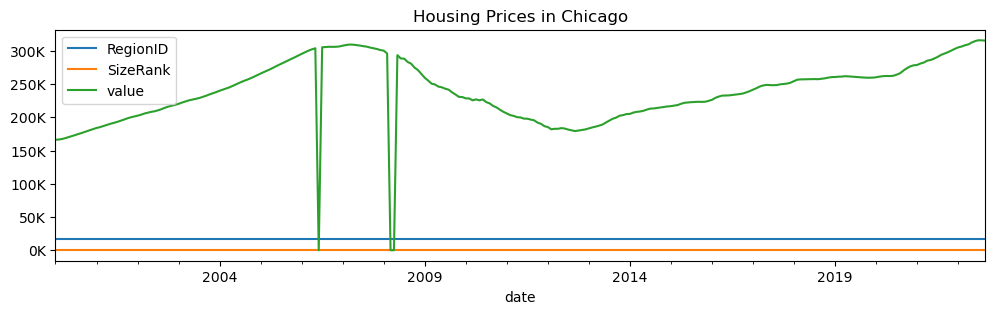

In [25]:
chicago_df = hvd_melt2.loc['Chicago'].copy()
ax = chicago_df.plot()
ax.set_title('Housing Prices in Chicago')
ax.yaxis.set_major_formatter(fmt_thous);

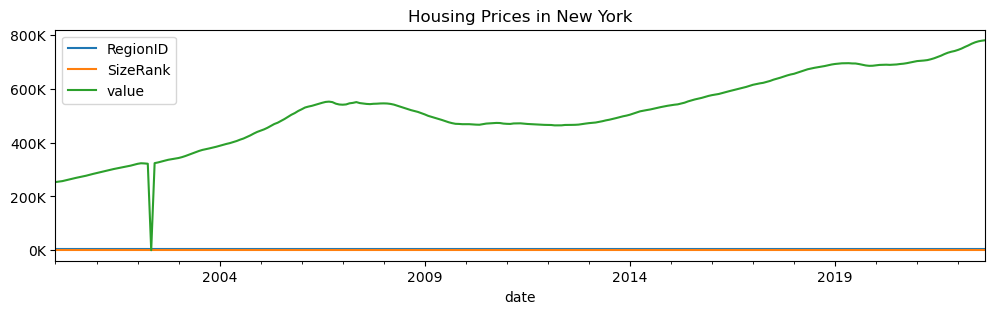

In [26]:
new_york_df = hvd_melt2.loc['New York'].copy()
ax = new_york_df.plot()
ax.set_title('Housing Prices in New York')
ax.yaxis.set_major_formatter(fmt_thous);

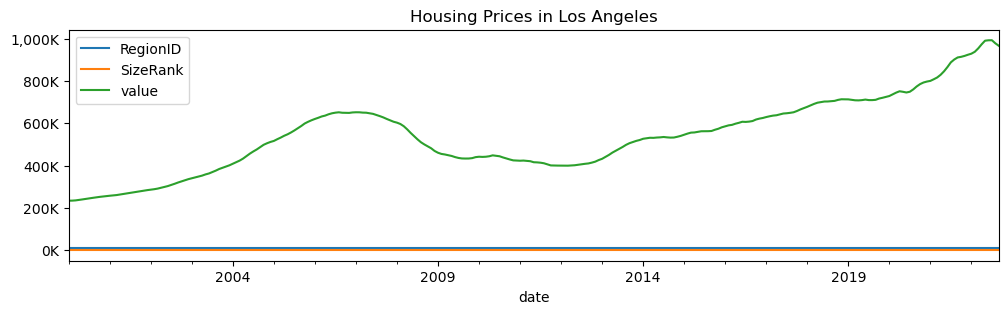

In [27]:
los_angeles_df = hvd_melt2.loc['Los Angeles'].copy()
ax = los_angeles_df.plot()
ax.set_title('Housing Prices in Los Angeles')
ax.yaxis.set_major_formatter(fmt_thous);

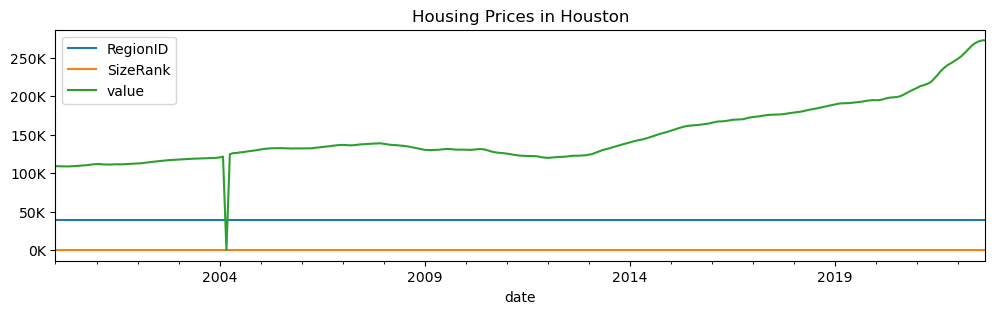

In [28]:
houston_df = hvd_melt2.loc['Houston'].copy()
ax = houston_df.plot()
ax.set_title('Housing Prices in Houston')
ax.yaxis.set_major_formatter(fmt_thous);

In [29]:
unstacked = hvd_melt2.unstack(level=0)
unstacked

RegionID                              SizeRank                      \
RegionName  Chicago Houston Los Angeles New York  Chicago Houston Los Angeles   
date                                                                            
2000-01-31    17426   39051       12447     6181        3       2           1   
2000-02-29    17426   39051       12447     6181        3       2           1   
2000-03-31    17426   39051       12447     6181        3       2           1   
2000-04-30    17426   39051       12447     6181        3       2           1   
2000-05-31    17426   39051       12447     6181        3       2           1   
...             ...     ...         ...      ...      ...     ...         ...   
2022-05-31    17426   39051       12447     6181        3       2           1   
2022-06-30    17426   39051       12447     6181        3       2           1   
2022-07-31    17426   39051       12447     6181        3       2           1   
2022-08-31    17426   39051       12447     6181        3       2           1   
2022-09-30    17426   39051       12447     6181        3       2           1   

                        value                                  
RegionName New York   Chicago   Houston Los Angeles  New York  
date                                                           
2000-01-31        0  166139.0  109068.0    234181.0  253690.0  
2000-02-29        0  166536.0  109079.0    234401.0  255517.0  
2000-03-31        0  167368.0  108878.0    235513.0  257207.0  
2000-04-30        0  168826.0  108881.0    237589.0  260310.0  
2000-05-31        0  170499.0  108834.0    240113.0  263204.0  
...             ...       ...       ...         ...       ...  
2022-05-31        0  312487.0  265558.0    990391.0  768797.0  
2022-06-30        0  314663.0  268901.0    992337.0  773944.0  
2022-07-31        0  315910.0  271059.0    992630.0  777692.0  
2022-08-31        0  315587.0  272400.0    978196.0  779960.0  
2022-09-30        0  315429.0  272639.0    966595.0  781622.0  

[273 rows x 12 columns]

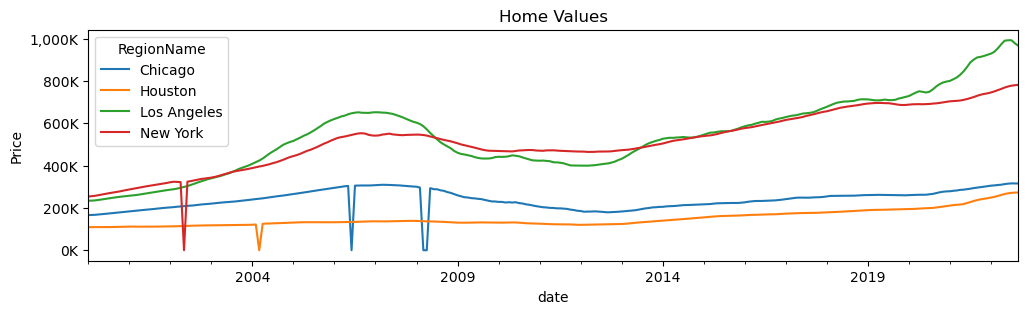

In [30]:
ax=unstacked['value'].plot(title='Home Values')
ax.set_ylabel('Price')
ax.yaxis.set_major_formatter(fmt_thous);

# 1) Which City had the highest Typical Home Value at the end of 2008? Which had the least?

In [31]:
unstacked.loc[pd.IndexSlice['2008'],:]

RegionID                              SizeRank                      \
RegionName  Chicago Houston Los Angeles New York  Chicago Houston Los Angeles   
date                                                                            
2008-01-31    17426   39051       12447     6181        3       2           1   
2008-02-29    17426   39051       12447     6181        3       2           1   
2008-03-31    17426   39051       12447     6181        3       2           1   
2008-04-30    17426   39051       12447     6181        3       2           1   
2008-05-31    17426   39051       12447     6181        3       2           1   
2008-06-30    17426   39051       12447     6181        3       2           1   
2008-07-31    17426   39051       12447     6181        3       2           1   
2008-08-31    17426   39051       12447     6181        3       2           1   
2008-09-30    17426   39051       12447     6181        3       2           1   
2008-10-31    17426   39051       12447     6181        3       2           1   
2008-11-30    17426   39051       12447     6181        3       2           1   
2008-12-31    17426   39051       12447     6181        3       2           1   

                        value                                  
RegionName New York   Chicago   Houston Los Angeles  New York  
date                                                           
2008-01-31        0  300207.0  138208.0    603029.0  546538.0  
2008-02-29        0  296063.0  137512.0    596635.0  546098.0  
2008-03-31        0       0.0  136795.0    586065.0  544562.0  
2008-04-30        0       0.0  136628.0    571226.0  541865.0  
2008-05-31        0  293467.0  136228.0    554589.0  537685.0  
2008-06-30        0  288495.0  135773.0    539622.0  533810.0  
2008-07-31        0  288174.0  135392.0    524220.0  529211.0  
2008-08-31        0  283199.0  134770.0    510520.0  525290.0  
2008-09-30        0  280695.0  133932.0    500124.0  521347.0  
2008-10-31        0  274849.0  133189.0    490979.0  518048.0  
2008-11-30        0  271059.0  132247.0    481905.0  514767.0  
2008-12-31        0  265306.0  131283.0    469294.0  510309.0

Highest: New York

Lowest: Chicago

# 2) How much did the home values change from November 2008 to December 2008 (in dollars)?

In [32]:
diff = unstacked.diff()
diff

RegionID                              SizeRank                      \
RegionName  Chicago Houston Los Angeles New York  Chicago Houston Los Angeles   
date                                                                            
2000-01-31      NaN     NaN         NaN      NaN      NaN     NaN         NaN   
2000-02-29      0.0     0.0         0.0      0.0      0.0     0.0         0.0   
2000-03-31      0.0     0.0         0.0      0.0      0.0     0.0         0.0   
2000-04-30      0.0     0.0         0.0      0.0      0.0     0.0         0.0   
2000-05-31      0.0     0.0         0.0      0.0      0.0     0.0         0.0   
...             ...     ...         ...      ...      ...     ...         ...   
2022-05-31      0.0     0.0         0.0      0.0      0.0     0.0         0.0   
2022-06-30      0.0     0.0         0.0      0.0      0.0     0.0         0.0   
2022-07-31      0.0     0.0         0.0      0.0      0.0     0.0         0.0   
2022-08-31      0.0     0.0         0.0      0.0      0.0     0.0         0.0   
2022-09-30      0.0     0.0         0.0      0.0      0.0     0.0         0.0   

                      value                               
RegionName New York Chicago Houston Los Angeles New York  
date                                                      
2000-01-31      NaN     NaN     NaN         NaN      NaN  
2000-02-29      0.0   397.0    11.0       220.0   1827.0  
2000-03-31      0.0   832.0  -201.0      1112.0   1690.0  
2000-04-30      0.0  1458.0     3.0      2076.0   3103.0  
2000-05-31      0.0  1673.0   -47.0      2524.0   2894.0  
...             ...     ...     ...         ...      ...  
2022-05-31      0.0  2838.0  4457.0     17223.0   6476.0  
2022-06-30      0.0  2176.0  3343.0      1946.0   5147.0  
2022-07-31      0.0  1247.0  2158.0       293.0   3748.0  
2022-08-31      0.0  -323.0  1341.0    -14434.0   2268.0  
2022-09-30      0.0  -158.0   239.0    -11601.0   1662.0  

[273 rows x 12 columns]

In [33]:
diff.loc[pd.IndexSlice['11/01/2008':'12/01/2008'],:]

RegionID                              SizeRank                      \
RegionName  Chicago Houston Los Angeles New York  Chicago Houston Los Angeles   
date                                                                            
2008-11-30      0.0     0.0         0.0      0.0      0.0     0.0         0.0   

                      value                               
RegionName New York Chicago Houston Los Angeles New York  
date                                                      
2008-11-30      0.0 -3790.0  -942.0     -9074.0  -3281.0

Chicago - $3790

Houston - $942

Los Angeles - $9074

New York - $3281

# Gridsearch SARIMA Models

In [34]:
hvd_melt

,RegionID,SizeRank,RegionName,RegionType,StateName,State,Metro,CountyName,value
date,,,,,,,,,
2000-01-31,6181,0,New York,city,NY,NY,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,253690.0
2000-01-31,12447,1,Los Angeles,city,CA,CA,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles County,234181.0
2000-01-31,39051,2,Houston,city,TX,TX,"Houston-The Woodlands-Sugar Land, TX",Harris County,109068.0
2000-01-31,17426,3,Chicago,city,IL,IL,"Chicago-Naperville-Elgin, IL-IN-WI",Cook County,166139.0
2000-02-29,6181,0,New York,city,NY,NY,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,255517.0
...,...,...,...,...,...,...,...,...,...
2022-08-31,17426,3,Chicago,city,IL,IL,"Chicago-Naperville-Elgin, IL-IN-WI",Cook County,315587.0
2022-09-30,6181,0,New York,city,NY,NY,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,781622.0
2022-09-30,12447,1,Los Angeles,city,CA,CA,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles County,966595.0


In [40]:
filter_ny = hvd_melt['SizeRank'] < 1

In [41]:
hvd_ny = hvd_melt[filter_ny]

In [42]:
hvd_ny

,RegionID,SizeRank,RegionName,RegionType,StateName,State,Metro,CountyName,value
date,,,,,,,,,
2000-01-31,6181,0,New York,city,NY,NY,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,253690.0
2000-02-29,6181,0,New York,city,NY,NY,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,255517.0
2000-03-31,6181,0,New York,city,NY,NY,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,257207.0
2000-04-30,6181,0,New York,city,NY,NY,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,260310.0
2000-05-31,6181,0,New York,city,NY,NY,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,263204.0
...,...,...,...,...,...,...,...,...,...
2022-05-31,6181,0,New York,city,NY,NY,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,768797.0
2022-06-30,6181,0,New York,city,NY,NY,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,773944.0
2022-07-31,6181,0,New York,city,NY,NY,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,777692.0


In [61]:
hvd_ny = hvd_ny.asfreq('M')

In [62]:
hvd_ny = hvd_ny.drop(columns= ['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName', 'State', 'Metro', 'CountyName']).copy()

In [63]:
hvd_ny

,value
date,
2000-01-31,253690.0
2000-02-29,255517.0
2000-03-31,257207.0
2000-04-30,260310.0
2000-05-31,263204.0
...,...
2022-05-31,768797.0
2022-06-30,773944.0
2022-07-31,777692.0


In [45]:
ny_df = hvd_ny.loc['2018':'2022']
ny_df.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,State,Metro,CountyName,value
date,,,,,,,,,
2018-01-31,6181,0,New York,city,NY,NY,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,656700.0
2018-02-28,6181,0,New York,city,NY,NY,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,661012.0
2018-03-31,6181,0,New York,city,NY,NY,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,665672.0
2018-04-30,6181,0,New York,city,NY,NY,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,669989.0
2018-05-31,6181,0,New York,city,NY,NY,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,673514.0


In [46]:
ny_df = ny_df.drop(columns= ['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName', 'State', 'Metro', 'CountyName']).copy()

In [53]:
ny_df = ny_df.asfreq('M')

In [55]:
ts = ny_df['value']

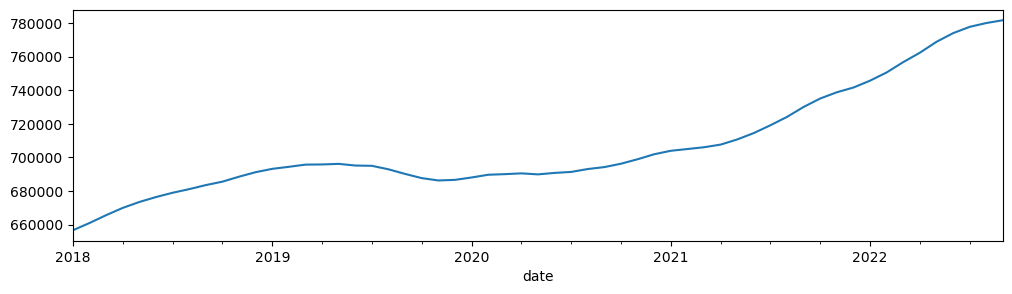

In [57]:
ts.plot();

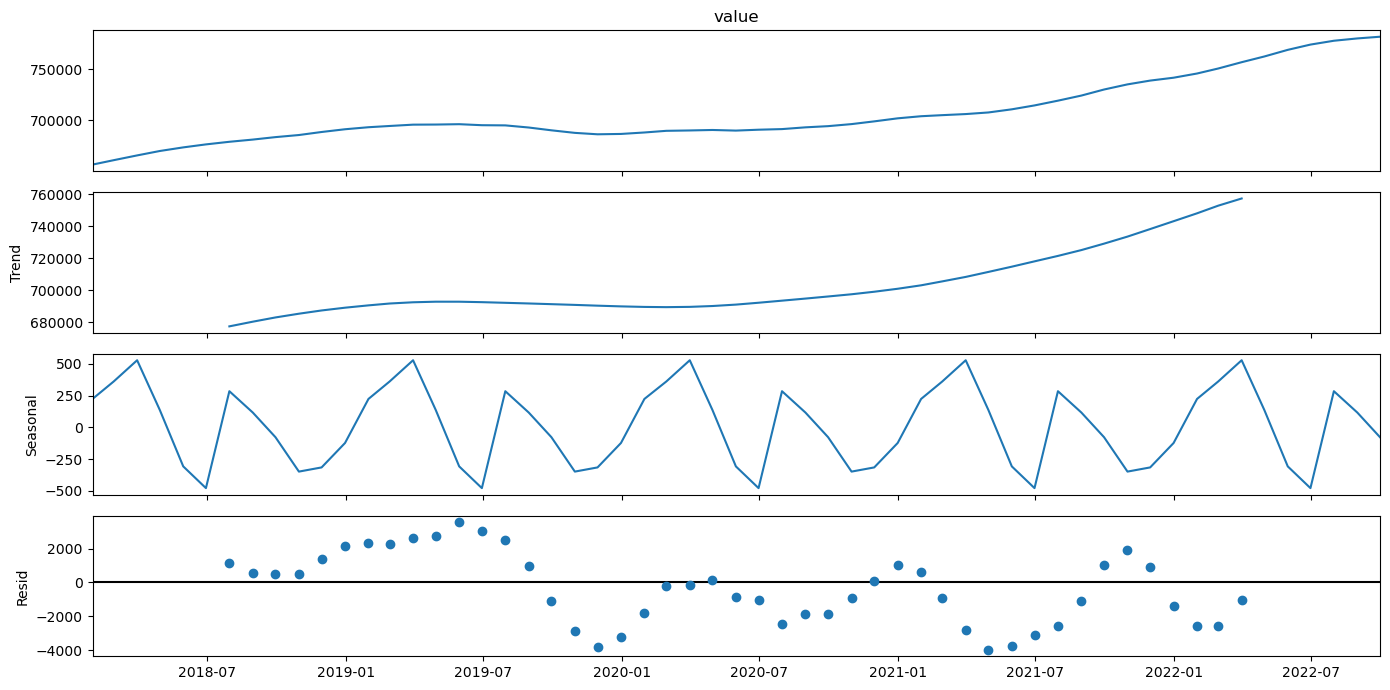

In [78]:
decomp = tsa.seasonal_decompose(ts)
fig = decomp.plot()
fig.set_size_inches(14,7)
fig.tight_layout()

In [81]:
ts.max(), ts.min()

(781622.0, 656700.0)

In [59]:
# How big is the seasonal component
seasonal_delta = decomp.seasonal.max() - decomp.seasonal.min()

# How big is the seasonal component relative to the time series?
print(f"The seasonal component is {seasonal_delta: .2f} which is ~{seasonal_delta/(ts.max()-ts.min()) * 100 :.2f}% of the variation in time series.")

The seasonal component is  1006.13 which is ~0.81% of the variation in time series.


In [74]:
get_adfuller_results(ts)

,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
adfuller,0.407572,4,52,0.981776,0.05,False


In [75]:
d = ndiffs(ts)
print (f'd = {d}')
# determine D
D = nsdiffs(ts, m = 12)
print (f'D = {D}')

d = 2
D = 0


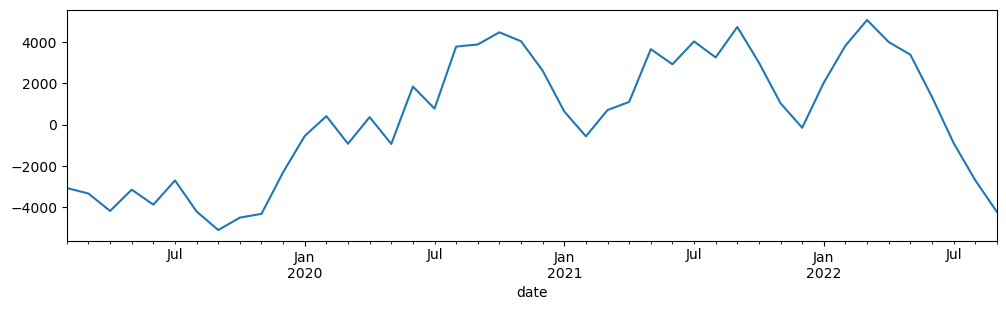

In [76]:
ts_diff = ts.diff().diff(12).dropna()
ts_diff.plot();

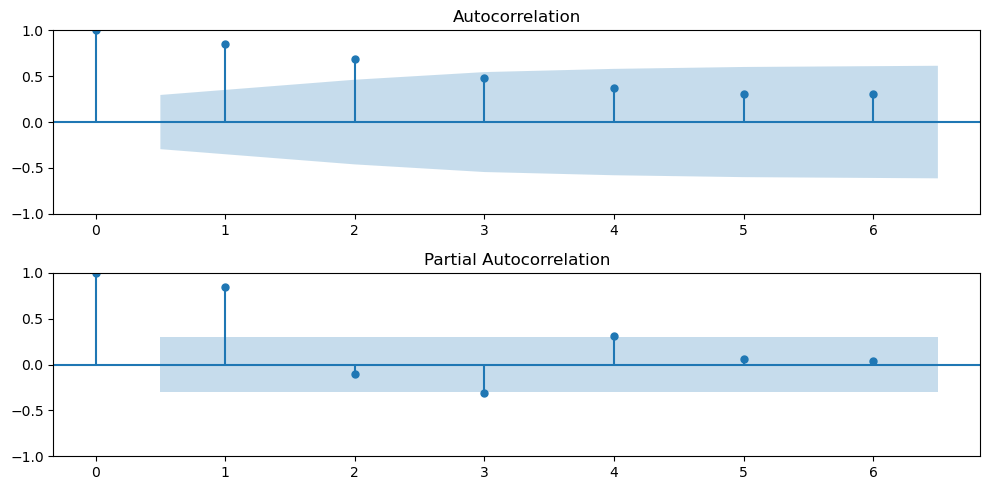

In [85]:
plot_acf_pacf(ts_diff, annotate_seas = True, m = 12, nlags = 6);

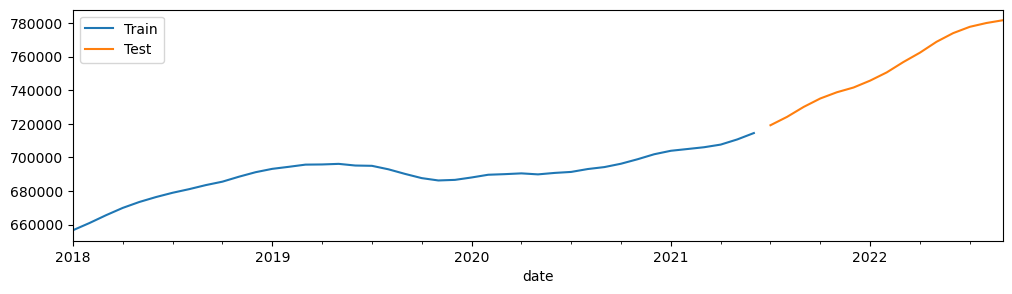

In [86]:
# train test split
train, test = train_test_split(ts, test_size=.25)
ax = train.plot(label='Train')
test.plot(ax=ax, label='Test')
ax.legend();

In [87]:
# orders for non seasonal components
p = 0
d = 2
q = 0

P = 0
D = 0
Q = 0
m = 12

sarima = tsa.ARIMA(train, order = (p,d,q), seasonal_order=(P,D,Q,m)).fit()

# Obtain summary
sarima.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                   42
Model:                 ARIMA(0, 2, 0)   Log Likelihood                -327.213
Date:                Thu, 26 Oct 2023   AIC                            656.427
Time:                        19:38:17   BIC                            658.116
Sample:                    01-31-2018   HQIC                           657.037
                         - 06-30-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      7.446e+05   2.07e+05      3.592      0.000    3.38e+05    1.15e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.26   Jarque-Bera (JB):                 0.87
Prob(Q):                              0.61   Prob(JB):                         0.65
Heteroskedasticity (H):               2.66   Skew:                             0.06
Prob(H) (two-sided):                  0.09   Kurtosis:                         2.29
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

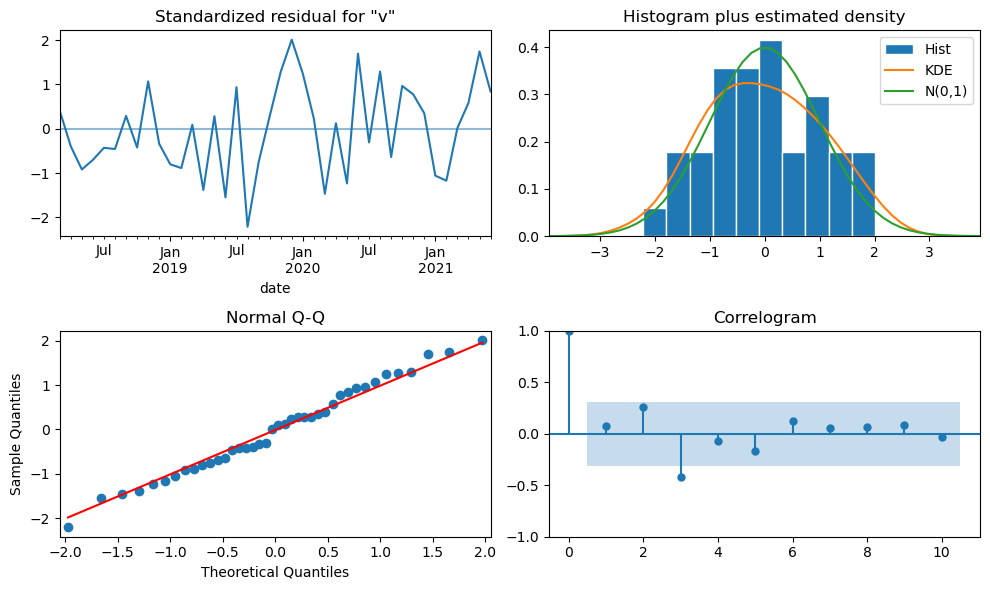

In [88]:
# Obtain diagnostic plots
fig = sarima.plot_diagnostics()
fig.set_size_inches(10,6)
fig.tight_layout()

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 7,492.333
- MSE = 73,224,450.200
- RMSE = 8,557.129
- R^2 = 0.822
- MAPE = 0.98%


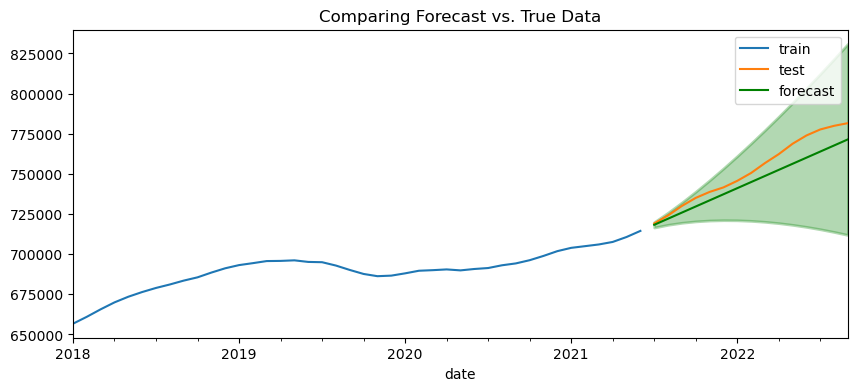

In [89]:
forecast_df = sarima.get_forecast(steps=len(test)).summary_frame()
# Call the custom function to plot the forecasts with confidence intervals and true values
plot_forecast(train, test, forecast_df);
# Obtain metrics
regression_metrics_ts(test, forecast_df['mean'])


In [90]:
# Default auto_arima will select model based on AIC score
auto_model = pm.auto_arima(
    train,
    seasonal=True,  
    m=12,
    trace=True)


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=768.630, Time=0.54 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=733.235, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=872.953, Time=0.07 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=734.033, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=751.534, Time=0.01 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=735.153, Time=0.05 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=735.153, Time=0.02 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=737.173, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=740.880, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=734.901, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=745.401, Time=0.06 sec

Best model:  ARIMA(0,1,0)(0,0,0)[12] intercept
Total fit time: 1.047 seconds


In [91]:
print(auto_model.order)
print(auto_model.seasonal_order)

(0, 1, 0)
(0, 0, 0, 12)


In [92]:
auto_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   42
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -364.617
Date:                Thu, 26 Oct 2023   AIC                            733.235
Time:                        19:39:54   BIC                            736.662
Sample:                    01-31-2018   HQIC                           734.483
                         - 06-30-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1409.9268    290.500      4.853      0.000     840.557    1979.297
sigma2      3.104e+06   7.44e+05      4.170      0.000    1.65e+06    4.56e+06
===================================================================================
Ljung-Box (L1) (Q):                  30.16   Jarque-Bera (JB):                 1.35
Prob(Q):                              0.00   Prob(JB):                         0.51
Heteroskedasticity (H):               0.45   Skew:                            -0.44
Prob(H) (two-sided):                  0.14   Kurtosis:                         2.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

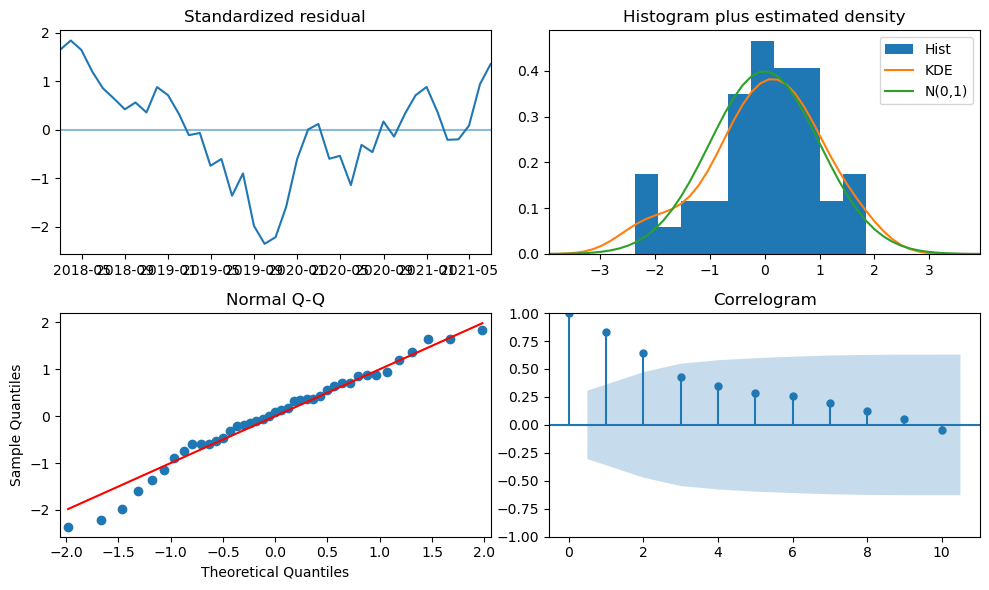

In [93]:
fig = auto_model.plot_diagnostics()
fig.set_size_inches(10,6)
fig.tight_layout()

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 37,900.333
- MSE = 1,846,971,743.000
- RMSE = 42,976.409
- R^2 = -3.499
- MAPE = 4.97%


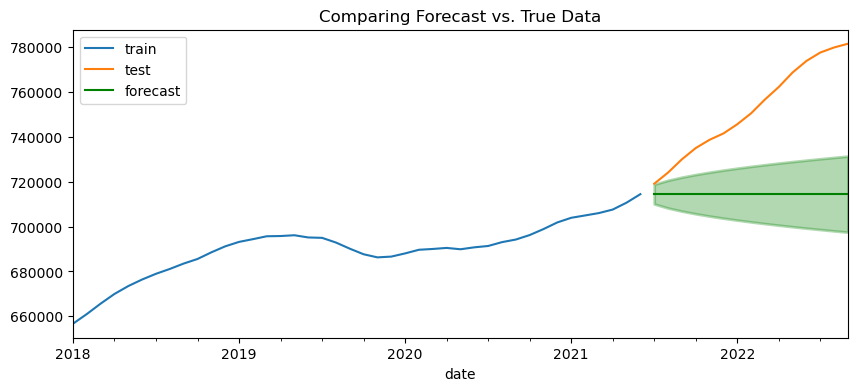

In [94]:
auto_model = tsa.ARIMA(
    train, order=auto_model.order, seasonal_order=auto_model.seasonal_order
).fit()


# Obtain forecast as a dataframe with confidence intervals
forecast_df = auto_model.get_forecast(steps=len(test)).summary_frame()
# Call the custom function to plot the forecasts with confidence intervals and true values
plot_forecast(train, test, forecast_df);
# Obtain metrics
regression_metrics_ts(test, forecast_df['mean'])

In [95]:
forecast_df.index[0],forecast_df.index[-1]

(Timestamp('2021-07-31 00:00:00', freq='M'),
 Timestamp('2022-09-30 00:00:00', freq='M'))

In [96]:
starting_value = forecast_df['mean'].iloc[0]
starting_value

714507.0

In [97]:
final_value = forecast_df['mean'].iloc[-1]
final_value

714507.0

In [98]:
change = final_value - starting_value
change

0.0

In [99]:
perc_change = (change / starting_value) * 100
perc_change

0.0

What is the predicted home value in New York City 6 months into the future (beyond the dataset)?

-  $714,507

What is the percent change in home values in New York City by the end of the 6-month forecast (beyond the dataset)?

- apparently 0%

In [100]:
forecast_df

value,mean,mean_se,mean_ci_lower,mean_ci_upper
2021-07-31,714507.0,2234.589387,710127.285282,718886.714718
2021-08-31,714507.0,3160.186617,708313.148046,720700.851954
2021-09-30,714507.0,3870.422352,706921.111585,722092.888415
2021-10-31,714507.0,4469.178773,705747.570564,723266.429436
2021-11-30,714507.0,4996.693770,704713.660168,724300.339832
2021-12-31,714507.0,5473.603782,703778.933721,725235.066279
2022-01-31,714507.0,5912.167800,702919.364042,726094.635958
2022-02-28,714507.0,6320.373234,702119.296092,726894.703908
2022-03-31,714507.0,6703.768160,701367.855845,727646.144155
2022-04-30,714507.0,7066.392097,700657.125989,728356.874011
